# Subsampling the hessian

## (1) Funções essenciais

In [1]:
import numpy as np
def pontos_aleatorios(W, N, P, erro=0):
    X = np.concatenate([np.ones(P).reshape(1,P), np.random.rand(N-1,P)]) # N variaveis se incluir a constante
    Y = []
    for p in range(P):
        if np.dot(W, X[:, p]) < np.mean(np.dot(W, X)) + np.random.uniform(-erro,erro):
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

In [2]:
def sigma(w, v):
    return 1 / (1 + np.exp(-np.dot(w, v)))

# Funcao Custo da regressao Logistica
def g_lr(w, x, y):
    cost = 0
    N, P = x.shape
    for p in range(P):
        s = sigma(w, x[:,p])
        cost += (s - y[p]) ** 2
    return cost/P

# Gradiente da funcao custo
def grad_lr(w, x, y):
    N, P = x.shape
    grad = np.zeros(N)
    for p in range(P):
        s = sigma(w, x[:,p])
        k = (s - y[p]) * s**2 * np.exp(-np.dot(x[:,p], w))
        grad += k * x[:,p]
    grad = 2*grad/P
    return grad

In [3]:
# Hessiana
def hessian(w, x, y):
    N, P = x.shape
    H = np.zeros((N, N))
    for p in range(P):
        x_p = x[:, p]
        s = sigma(w, x_p)
        A = s * (1 - s)  # A = derivada da função sigmoide
        H += (2 / P) * A * (1 - 2 * (s - y[p])) * np.outer(x_p, x_p)
    return H

## (2) Métodos de minimização da função custo

### (2.1) Newton com hessiana sub-amostrada

In [4]:
# metodo de newton modificado
def subsampled_hessian_newton_method(w_init, x, y, max_iter=100, tol=1e-10):
    w = w_init.copy()
    cost = g_lr(w, x, y)
    cost_history = [cost]
    alpha = 1
    epsilon = 1e-10
    i = 0
    while cost > tol and i in range(max_iter):
        
        # Computando o gradiente e a hessiana de g
        gradient = grad_lr(w, x, y)
        try:
            H_diag_inv = 1/np.diag(hessian(w, x, y))
        except np.linalg.LinAlgError:
            H_diag_inv = 1/(np.diag(hessian(w, x, y)) + epsilon)

        k = np.array([gradient[i] * H_diag_inv[i] for i in range(N)])
        
        # Passo iterativo de Newton
        w_new = w - alpha * k
        new_cost = g_lr(w_new, x, y)

        if new_cost > cost:
            alpha /= 2
        else:
            w = w_new
       
        cost_history.append(new_cost)
        cost = new_cost
        i += 1
        
    return w, cost_history

### (2.2) Newton original

In [5]:
# metodo de newton modificado
def original_newton_method(w_init, x, y, max_iter=100, tol=1e-10):
    w = w_init.copy()
    cost = g_lr(w, x, y)
    cost_history = [cost]
    alpha = 1
    epsilon = 1e-10
    i = 0
    while cost > tol and i in range(max_iter):
        
        # Computando o gradiente e a hessiana de g
        gradient = grad_lr(w, x, y)
        H = hessian(w, x, y)
        
        try:
            delta_w = np.linalg.solve(H, -gradient) # mais fácil/estável resolver o sistema do que inverter 
            w_new = w + alpha * delta_w
        except np.linalg.LinAlgError :
            H_inv = np.linalg.inv(H + epsilon*np.eye(N))
            w_new = w - alpha * H_inv @ gradient
        
        new_cost = g_lr(w_new, x, y)

        if new_cost > cost:
            alpha /= 2
        else:
            w = w_new
       
        cost_history.append(new_cost)
        cost = new_cost
        i += 1
        
    return w, cost_history

### (2.3) gradiente descendente normalizado

In [6]:
#Gradiente Descendente
def gradient_descent(w, x, y, max_its=100, tol = 1e-10):
    cost = g_lr(w,x,y)
    cost_history = [cost]
    alpha = 1
    i = 0
    while cost > tol and i in range(max_its):
        w_ant = w.copy()
        grad = grad_lr(w,x,y)
        w -= alpha * grad
        
        new_cost = g_lr(w,x,y)
        if new_cost > cost:
            w = w_ant
            alpha /= 2
        cost_history.append(new_cost)
        cost = g_lr(w,x,y)
        i += 1
    
    return w, cost_history

## (3) Teste dos modelos usando dados aleatórios

In [7]:
# gera os dados aleatorios
P = 500
N = 3
w_true = np.array(np.random.uniform(-1,1,N))
x, y = pontos_aleatorios(w_true, N, P, erro = 0.01)

max_iter = 1000

# Roda o metodo de newton com hessiana sub-amostrada
w_init = np.zeros(N)
w_newton_subsample, cost_history_newton_subsample = subsampled_hessian_newton_method(w_init, x, y, max_iter)

# Roda o metodo de newton com hessiana sub-amostrada
w_init = np.ones(N)
w_newton_original, cost_history_newton_original = original_newton_method(w_init, x, y, max_iter)

# Roda o metodo do gradiente descendente normalizado
w_init = np.ones(N)
w_grad_desc, cost_history_grad_desc = gradient_descent(w_init, x, y, max_iter)


print("modelo 1:", w_newton_subsample)
print("modelo 2:", w_newton_original)
print("modelo 3:", w_grad_desc)
print('modelo real:', w_true)

modelo 1: [ 15.52707569 -16.58217028 -13.9766238 ]
modelo 2: [0.0813846  3.35635148 3.05917456]
modelo 3: [ 6.32666314 -6.82107964 -5.63716093]
modelo real: [ 0.9013979  -0.79574647 -0.6951172 ]


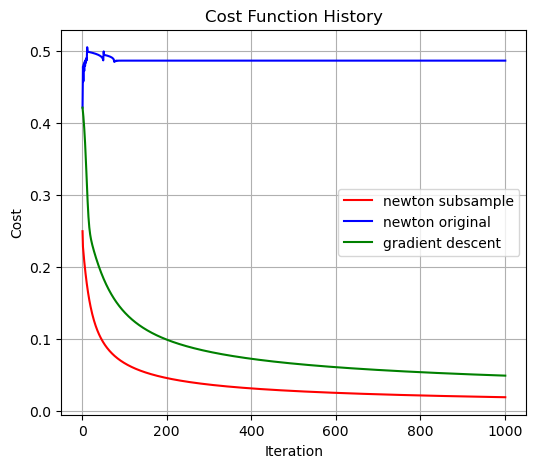

In [8]:
# Plot the cost function history
import matplotlib.pyplot as plt

k = min(len(cost_history_newton_subsample),len(cost_history_newton_original) ,len(cost_history_grad_desc)) 
iteracoes = [i for i in range(1, k+1)]

plt.figure(figsize=(6, 5))
plt.plot(iteracoes, cost_history_newton_subsample[:k], color='red', label='newton subsample')
plt.plot(iteracoes, cost_history_newton_original[:k],  color='blue', label='newton original')
plt.plot(iteracoes, cost_history_grad_desc[:k], color='green', label='gradient descent')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function History')
plt.grid(True)
plt.show()

## (4) Medindo a qualidade das previsões

In [9]:
def acuracia(modelo, y, P):
    erros = 0
    for p in range(P):
        if modelo[p] > 0.5 and y[p] == 0: # falso positivo
            erros += 1
        elif modelo[p] < 0.5 and y[p] == 1: # falso negativo
            erros += 1
    return 100*(1-erros/P)

# Estimando os modelos
modelo_newton_subsample = []
modelo_newton_original = []
modelo_grad_desc = []

for p in range(P):
    # Newton subsampled
    modelo_newton_subsample.append(sigma(x[:,p], w_newton_subsample))

    # Newton original
    modelo_newton_original.append(sigma(x[:,p], w_newton_original))

    # Gradiente Descendente
    modelo_grad_desc.append(sigma(x[:,p], w_grad_desc))

#print(modelo_newton_subsample)
    

# acuracia
print('Acurácias:')
print('newton subsample: ', acuracia(modelo_newton_subsample, y, P),'%')
print('newton original: ', acuracia(modelo_newton_original, y, P),'%')
print('gradient descent: ', acuracia(modelo_grad_desc, y, P),'%')

Acurácias:
newton subsample:  99.8 %
newton original:  51.0 %
gradient descent:  99.4 %


## (5) Comparação da modelagem e da velocidade

In [10]:
import time
P = 500
N_vector = [i*10 for i in range(1,16)] # N = 10, 20, ..., 140, 150.
time_matrix = [[],[],[]]

for N in N_vector:
    w_true = np.array(np.random.uniform(-1,1,N))
    x, y = pontos_aleatorios(w_true, N, P, erro = 0)
    max_iter = 1000

    # Roda o metodo de newton com hessiana sub-amostrada
    w_init = np.zeros(N)
    start = time.time()
    w_newton_subsample, cost_history_newton_subsample = subsampled_hessian_newton_method(w_init, x, y, max_iter)
    end = time.time()
    time_matrix[0].append(end-start)
    
    # Roda o metodo de newton original
    w_init = np.ones(N)
    start = time.time()
    w_newton_original, cost_history_newton_original = original_newton_method(w_init, x, y, max_iter)
    end = time.time()
    time_matrix[1].append(end-start)

    # Roda o metodo do gradiente descendente normalizado
    w_init = np.ones(N)
    start = time.time()
    w_grad_desc, cost_history_grad_desc = gradient_descent(w_init, x, y, max_iter)
    end = time.time()
    time_matrix[2].append(end-start)



C:\Users\Daniel\AppData\Local\Temp\ipykernel_13484\3601496418.py:14: RuntimeWarning: divide by zero encountered in divide
  H_diag_inv = 1/np.diag(hessian(w, x, y))
C:\Users\Daniel\AppData\Local\Temp\ipykernel_13484\436539264.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  k = (s - y[p]) * s**2 * np.exp(-np.dot(x[:,p], w))
C:\Users\Daniel\AppData\Local\Temp\ipykernel_13484\436539264.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-np.dot(w, v)))
C:\Users\Daniel\AppData\Local\Temp\ipykernel_13484\436539264.py:19: RuntimeWarning: overflow encountered in exp
  k = (s - y[p]) * s**2 * np.exp(-np.dot(x[:,p], w))


KeyboardInterrupt: 

In [ ]:
colors = ['blue', 'red', 'green']
models = ['newton subsampled', 'original newton', 'gradient descent']
i = 0
for v in time_matrix:
    plt.plot(N_vector, v, color = colors[i], label = models[i])
    i += 1
plt.legend()
plt.xlabel('N (dimensão das observações)')
plt.ylabel('tempo (s)')
plt.xticks(np.arange(0, 110, 10))
plt.yticks(np.arange(0, 50, 5))
plt.title('Tempo computacional')
plt.grid(True)
plt.show()

In [ ]:
time_matrix[1][7]=35